In [34]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#LW=5 # linewidth
#MS=10 # markersize
import pickle
import time

In [35]:
def compute_gaussian_predicted_marginal(mu, Sigma, A, Gamma):
    """Compute the marginal distribution of Y where 
    
    Y = A theta + xi,  xi ~ N(0, Gamma)
    
    with theta distributed according to a Gaussian with mean mu and
    covariance Sigma
    
    theta is a vector of size (d)

    Inputs
    ------
    mu   : (d, ) array, the mean of theta
    Sigma: (d, d) array, the covariance of sigma
    A    : (n, d) linear model
    Gamma: (n, n) array, the covariance of xi

    Returns
    -------
    (mean, covariance, ASigma) 
    """
    ASigma = np.dot(A, Sigma)
    cov = np.dot(ASigma, A.T) + Gamma
    return np.dot(A, mu), cov, ASigma

def linear_gaussian_inverse_problem(prior_mean, prior_cov, A, Gamma, data):
    """Compute the posterior of a linear-Gaussian inverse problem
    
    Inputs
    ------
    prior_mean: (d, ) prior mean
    prior_cov : (d, d) prior Covariance
    A         : (M, d) linear model
    Gamma     : (M, M) noise model
    data      : (M, ) data
    
    Outputs
    -------
    (post_mean, post_covcov): posterior mean and posterior covariance
    """
            
    # Compute Marginal
    mean_pred, cov_pred, ASigma = compute_gaussian_predicted_marginal(prior_mean, prior_cov, A, Gamma)
    
    # Condition
    delta = data - mean_pred
    update = np.linalg.solve(cov_pred, delta)
    
    # Use two Gaussian conditiong equations for the posterior mean and covariance
    post_mean = prior_mean + np.dot(ASigma.T, update)
    post_cov = prior_cov - np.dot(ASigma.T, np.linalg.solve(cov_pred, ASigma))
    return post_mean, post_cov

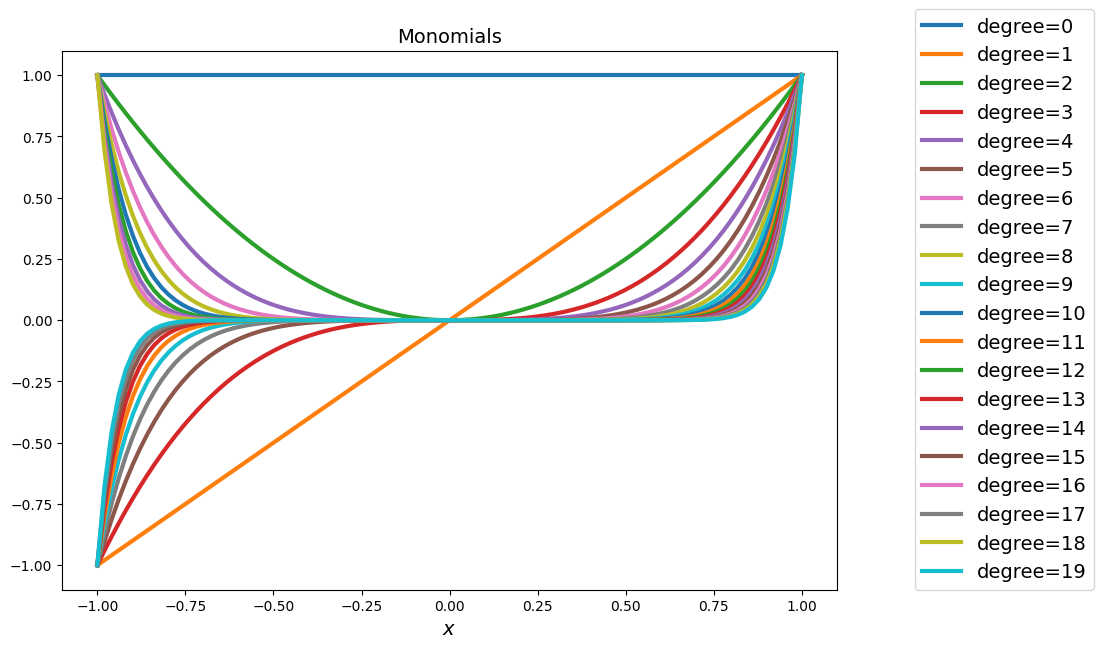

In [36]:
XSPACE = np.linspace(-1, 1, 100)
def monomial(x, param=5):
    "Parameter is the degree-1 of the monomial"
    return np.array([x**ii for ii in range(param)]).T

plt.figure(figsize=(10, 7))
MONOMIALS = monomial(XSPACE, param=20)
for ii in range(MONOMIALS.shape[1]):
    plt.plot(XSPACE, MONOMIALS[:, ii], label='degree={0}'.format(ii), lw=3)
plt.title("Monomials", fontsize=14)
plt.xlabel(r"$x$", fontsize=14)
plt.legend(fontsize=14, loc=(1.1, 0))
plt.show()

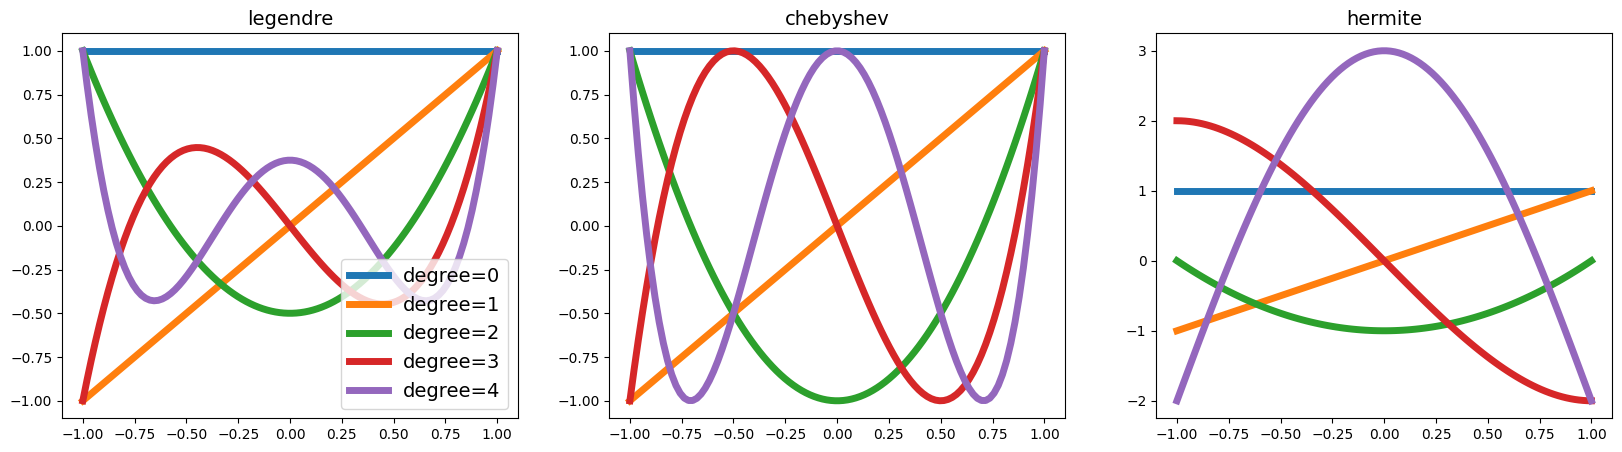

In [37]:
def legendre(x, num_param=5):
    "Legendre polynomials are on [-1,1]"
    return np.polynomial.legendre.legvander(x, num_param-1)

def chebyshev(x, num_param=5):
    "Chebyshev polynomials are on [-1,1]"
    return np.polynomial.chebyshev.chebvander(x, num_param-1)

def hermite(x, num_param=5):
    "Hermite polynomials are on [-inf,inf]"
    return np.polynomial.hermite_e.hermevander(x, num_param-1)

POLYOPTIONS = {"legendre":legendre, "chebyshev":chebyshev, "hermite":hermite}

fig, axs = plt.subplots(1, len(POLYOPTIONS), figsize=(20,5))
for ii, (polyname, polyfunc) in enumerate(POLYOPTIONS.items()):
    vandermonde = polyfunc(XSPACE)
    for jj in range(vandermonde.shape[1]):
        axs[ii].plot(XSPACE, vandermonde[:, jj], label='degree={0}'.format(jj), lw=5)
    if ii == 0:
        axs[ii].legend(fontsize=14)
    axs[ii].set_title(polyname, fontsize=14)
plt.show()

### Kernel features

A kernel is a symmetric positive definite function. One common kernel has an exponential form

\begin{equation}
K(x, x^{\prime}) = \gamma \exp\left(-\frac{1}{\sigma^2}\lvert x - x^{\prime} \rvert_{\alpha}^{\alpha} \right)
\end{equation}

1. $\gamma$ is a scaling factor, it governs how large this function can become
2. $\sigma^2$ is a distance factor, it governs how fast the function decays with distance between $x^{\prime}$ and $x^{\prime}$
3. $\alpha$: governs how to measure distance

To use these as features you would have to choose some set of points $x_1,\ldots, x_m$ at which to "anchor" these functions so that we have 
\begin{equation}
f(x; \theta) = \sum_{i=1}^m \theta_i K(x, x_i) 
\end{equation}

In [38]:
def exp_kernel(x, xprime, gamma=1, sigma_squared=0.1, alpha=2.0):
    """Exponential kernel"""
    dist = np.array([np.abs(xx-xp)**alpha for xx, xp in zip(x, xprime)])
    in_exp = -dist / sigma_squared
    kern_val = gamma * np.exp(in_exp)
    return kern_val

def kernel_vand(xlocs, gamma=1, sigma_squared=0.1, alpha=2):
    "This funciton build another function that returns a vandermonde matrix"
    def kernel(x, num_param=None):
        #num_param is ignored because it is obtained from xlocs
        A = np.zeros((x.shape[0], xlocs.shape[0]))
        for ii in range(xlocs.shape[0]):
            xtile = xlocs[ii]*np.ones(x.shape)
            A[:, ii] = exp_kernel(x, xtile, gamma=gamma, sigma_squared=sigma_squared, alpha=alpha)
        return A
    
    return kernel

In [39]:
@interact_manual(ss=(0.001,1.0,0.001), gamma=(1, 10, 1))
def plot_kernel_vand(ss, gamma):
    plt.figure(figsize=(7,7))
    NKERNELS=10
    XKERN = np.linspace(-1, 1, NKERNELS)
    kern_func = kernel_vand(XKERN, gamma=gamma, sigma_squared=ss, alpha=2.0)
    KVAND = kern_func(XSPACE)
    for ii in range(KVAND.shape[1]):
        plt.plot(XSPACE, KVAND[:, ii], lw=5)
        plt.plot(XKERN, np.zeros((NKERNELS)), 'ko', ms=5)
    plt.xlabel(r"$x$",fontsize=14)
    plt.title("Kernels", fontsize=14)
    plt.show()
#plot_kernel_vand(0.1, 1.0)

interactive(children=(FloatSlider(value=0.5, description='ss', max=1.0, min=0.001, step=0.001), IntSlider(valu…

## Regression of nonlinear functions (but parametric-linear because linear in parameters)

Regression using feature maps is virtually identical to the linear case. We set up the same linear Gaussian system
and plug in the features. In other words the sampling model is now
\begin{equation}
Y = \phi^T(x) \theta + \xi = \sum_{i=1}^m \theta_i \phi_i(x) + \xi 
\end{equation}

So that the linear Gaussian system is virtually identical

\begin{equation}
\begin{bmatrix}
Y_1 \\
Y_2 \\
\vdots \\
Y_N 
\end{bmatrix}
= 
\begin{bmatrix}
\phi^T(x^{(1)}) \\
\phi^T(x^{(2)}) \\
\vdots  \\
\phi^T(x^{(N)}) 
\end{bmatrix}
\theta
+ 
\xi \quad 
\xi \sim \mathcal{N}\left(
\begin{bmatrix}
0 \\
0 \\
\vdots \\
0
\end{bmatrix}
\begin{bmatrix}
\sigma^2 & 0 & \cdots &0 \\
0 & \sigma^2 & \ddots & \vdots \\
0 & \ddots & \ddots & \vdots \\
0 & \cdots & 0 & \sigma^2
\end{bmatrix}
\right)
\end{equation}

We now have $y = A(x) \theta + \xi$. With $A(x)$ being a slightly different **Vandermonde** matrix composed of the feature maps.

In [40]:
def bayesian_parametric_regression(xtrain, ytrain, xpredict, vand_func, prior_mean, prior_cov, noise_var):
    """Perform Bayesian parametric regression (ONLY FOR 1D inputs for now)
    
    Inputs
    ------
    xtrain    : (N) training inputs
    ytrain    : (N) training outputs
    xpredict  : (M) an array of points where predictions are required (If none, then is ignored)
    vand_func : a function func(x, p) -> features. It should return an N x p matrrix
    prior_mean: (p) prior mean
    prior_cov : (p, p) prior covariance
    noise_var : (N, ) noise variance of each individual output
    
    Outputs
    -------
    post_mean : posterior mean of the parameters
    post_cov  : posterior covariance of the parameters
    pred_mean : mean prediction at the predict points (optional)
    pred_cov  : covariance of the prediction (optional)
    
    Notes
    -----
    Predictions assumes no noise: just y = \phi^T(x) theta 
    This is almost exactly the same as the linear regression function above, but it uses the vand_func 
    to compute the A matrix
    """
    
    num_params = prior_mean.shape[0]

    # Perform inference
    A = vand_func(xtrain, num_param=num_params)
    Gamma = np.diag(noise_var)
    post_mean, post_cov = linear_gaussian_inverse_problem(prior_mean, prior_cov, A, Gamma, ytrain)
    
    # Perform prediction: which is just computing the marginal with a different
    
    if xpredict is not None:
        Apred = vand_func(xpredict, num_param=num_params)
        pred_mean, pred_cov, _ = compute_gaussian_predicted_marginal(post_mean, post_cov, Apred, 0)
    
        return post_mean, post_cov, pred_mean, pred_cov
    else:
        return post_mean, post_cov

In [41]:
def plot_function_pred(axis, Apred, param_mean, param_cov, xdata, ydata, xpred, ytrue, title, nsample=40):
    """Helper function for plotting distributions over functions and associated data"""
    pred_fmean, pred_fcov, _ = compute_gaussian_predicted_marginal(param_mean, param_cov, Apred, 0)
    pred_fstd = np.sqrt(np.diag(pred_fcov))
    axis.plot(xdata, ydata, 'o', ms=8, label='data')
    axis.plot(xpred, ytrue, '-', lw=2, color='black', label='true function')
    axis.plot(xpred, pred_fmean, 'r--', lw=3, label='prior mean')
    axis.fill_between(xpred, pred_fmean - 2*pred_fstd, pred_fmean+2*pred_fstd, lw=3, label=r'2$\sigma$', color='red', alpha=0.2)
    # if nsample > 0:
    #     sqrt_cov = np.linalg.cholesky(pred_fcov + 1e-10*np.eye(xpred.shape[0]))
    #     samples = np.tile(pred_fmean[:, np.newaxis], (1, nsample)) + np.dot(sqrt_cov, np.random.randn(xpred.shape[0], nsample))
    #     axs1.plot(xpred, samples, '-', color='grey', alpha=0.1)        
    axis.legend(fontsize=16)
    axis.set_title(title, fontsize=20)

In [42]:
# file = open('velocity-risk-ego-rover-overtake_7.dat', 'rb')
# data = pickle.load(file)
# file.close()

# data = np.asarray(data)
# data[:,0] = data[:,0] - data[0,0]
# # Subsample data : 
# ref_data = data[660:1200,:]
# # ref_data = data[800:1200,:]
# start = 00
# end = 190
# print("time interval :", ref_data[start,0], " - ", ref_data[end,0],"traj end- " , data[1200,0])
# # scale [-1,1]
# ref_data[:,0] = 2*ref_data[:,0]/(ref_data[-1,0]-ref_data[0,0]) 
# ref_data[:,0] = ref_data[:,0] + (-1 - ref_data[0,0])
# data_pts = ref_data[start:end,:]

# plt.plot(ref_data[:,0],ref_data[:,1])
# plt.plot(ref_data[:,0],ref_data[:,2])
# plt.plot(ref_data[end,0],ref_data[end,1], ".r")
# plt.show()
# XSPACE = ref_data[:,0]
# #NUM_DATA = 20
# NUM_DATA = 10
# #NUM_DATA = 100 
# NOISE_COV = 1e-4
# #NOISE_COV = 1e-2



# #XDATA = np.random.rand(NUM_DATA)*2.0 - 1.0 # randomly spaced data
# data_idx = np.random.choice(data_pts.shape[0],NUM_DATA, replace = False)
# XDATA = data_pts[data_idx, 0] # linearly space data
# YDATA = data_pts[data_idx, 1]
# YTRUE =ref_data[:,1] 

# def true_function(x):
#     return np.exp(-x**2 / 0.1)*np.sin(x) - x**3
#     #return x**5 + 0.2*x**6 - x - 0.5
# XSPACE = np.linspace(-1,1,1000)
# #NUM_DATA = 20
# NUM_DATA = 10
# #NUM_DATA = 100 
# NOISE_COV = 1e-4
# #NOISE_COV = 1e-2


# #XDATA = np.random.rand(NUM_DATA)*2.0 - 1.0 # randomly spaced data
# XDATA = np.linspace(-1, 0.5, NUM_DATA) # linearly space data
# YDATA = true_function(XDATA) + np.random.randn(NUM_DATA)*np.sqrt(NOISE_COV)
# YTRUE = true_function(XSPACE)  

In [43]:
# ## Legendre Basis
# @interact_manual(degree=(0,20,1), log_noise_learn=(-10,0,1))
# def legendre_infer(degree=1, log_noise_learn=np.log10(NOISE_COV)):
#     prior_cov = np.eye(int(degree+1))*10**(-15)
#     prior_mean = np.zeros((int(degree+1)))
#     noise_var = 10**(log_noise_learn) * np.ones((YDATA.shape[0]))
        
#     vand_func = POLYOPTIONS["hermite"]
#     post_mean, post_cov = bayesian_parametric_regression(XDATA,
#                                                          YDATA, None, vand_func, prior_mean, prior_cov, noise_var)
    
#     fig, axis = plt.subplots(1, 2, figsize=(20, 10))
#     Apred = vand_func(XSPACE, num_param=degree+1)
#     plot_function_pred(axis[0], Apred, prior_mean, prior_cov, XDATA, YDATA, XSPACE, YTRUE, "Prior", nsample=100)
#     plot_function_pred(axis[1], Apred, post_mean, post_cov, XDATA, YDATA, XSPACE, YTRUE, "Posterior", nsample=100)

In [44]:
# Kernel Basis
# @interact_manual(nkernels=(2,300, 2), log_sigma=(-4,1,0.5), gamma=(0.1, 10.5, 1), log_noise_learn=(-10,0,1))
# def kern_infer(nkernels=10, gamma=1, log_sigma=1, log_noise_learn=np.log10(NOISE_COV)):
    
#     prior_cov = np.eye(int(nkernels))
#     prior_mean = np.zeros(int(nkernels))
#     noise_var = 10**(log_noise_learn) * np.ones((YDATA.shape[0]))
    
#     xkern = np.linspace(-1, 1, nkernels)
#     vand_func = kernel_vand(xkern, gamma=gamma, sigma_squared=10**log_sigma, alpha=2.0)
    
#     post_mean, post_cov = bayesian_parametric_regression(XDATA,
#                                                          YDATA, None, vand_func, prior_mean, prior_cov, noise_var)
    
#     fig, axis = plt.subplots(1, 2, figsize=(20, 10))
#     Apred = vand_func(XSPACE, num_param=nkernels)
#     plot_function_pred(axis[0], Apred, prior_mean, prior_cov, XDATA, YDATA, XSPACE, YTRUE, "Prior", nsample=0)
#     plot_function_pred(axis[1], Apred, post_mean, post_cov, XDATA, YDATA, XSPACE, YTRUE, "Posterior", nsample=0)

In [45]:
def sqexp(x, xp, tau=0.7, l=10**0.7):

    """Squared exponential kernel (1 dimensional)

    

    Inputs

    ------

    x : (N), array of multiple inputs

    xp: float

    

    Returns

    -------

    cov (N,) -- Covariance between each input at *x* and the function values at *x*

    """

    cov = tau**2 * np.exp(-1/2 * (x - xp)**2 / l**2)

    return cov

def periodic(x, xp, tau=1, l=1.0, p=0.4):

    """Periodic kernel"""

    return tau**2 * np.exp ( -2 * np.sin(np.pi * np.abs(x - xp) / p )**2 / l**2)

def poly(x, xp, c=1, d=3):

    """Polynomial kernel"""

    return (x * xp + c)**d

    

KERNELS = {"Sq.Exp":sqexp, "Periodic":periodic, "Poly":poly}

# Lets also write some code to build a covariance matrix from kernel and a set of input points


In [46]:
x = np.array([1,2,3])
xp = 3
print(sqexp(x,xp))

[0.45249828 0.48034281 0.49      ]


In [47]:
def build_covariance(x, xp, kern):
    """Build a covariance matrix
    
    Inputs
    -------
    x: (N) array of inputs
    xp: (M) array of inptus
    kern: a function mapping inputs to covariance
    
    Outputs
    -------
    cov: (N, M) covariance matrix
    """
    out = np.zeros((x.shape[0], xp.shape[0]))
    for jj in range(xp.shape[0]):
        out[:, jj] = kern(x, xp[jj])
    return out

In [48]:
x = np.array([1,2,3])
xp = np.array([3,4,3])
print(build_covariance(x,xp, sqexp))

[[0.45249828 0.40963117 0.45249828]
 [0.48034281 0.45249828 0.48034281]
 [0.49       0.48034281 0.49      ]]


In [49]:
def sample_functions(x, nsamples, mean_func, kern):
    """Generate samples of functions from a Gaussian process
    
    Inputs
    ------
    x        : (N,) locations at which to obtain samples
    nsampels : integer, number of functions to sample
    mean_func: function to evaluate the prior mean at each location
    kern     : covariance kernel function
    
    Returns
    -------
    out: (N, nsamples) : array of functions, each column is a function
    """
    cov = build_covariance(x, x, kern)
    # print("cov = ", cov)
    u, s, v = np.linalg.svd(cov)
    sqrtcov = np.dot(u, np.sqrt(np.diag(s)))
    out = np.tile(mean_func(x)[:, np.newaxis], (1, nsamples)) + \
                  np.dot(sqrtcov, np.random.randn(x.shape[0], nsamples))
    return out

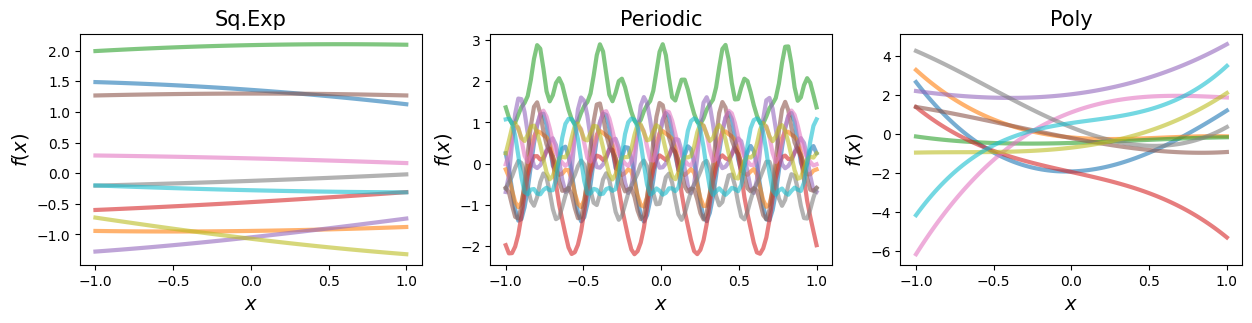

In [50]:
fig, axs = plt.subplots(1, len(KERNELS),  figsize=(15,3))
XSPACE2 = np.linspace(-1, 1, 100)
mean_func = lambda x: np.zeros((x.shape[0]))
#mean_func = lambda x: 10*x**2
for ii, (kname, kfunc) in enumerate(KERNELS.items()):
    #print(kname)
    funcs = sample_functions(XSPACE2, 10, mean_func, kfunc)
    for jj in range(funcs.shape[1]):
        axs[ii].plot(XSPACE2, funcs[:, jj], lw=3, alpha=0.6)
    axs[ii].set_title(kname, fontsize=15)
    axs[ii].set_xlabel(r'$x$', fontsize=14)
    axs[ii].set_ylabel(r'$f(x)$', fontsize=14)
plt.show()

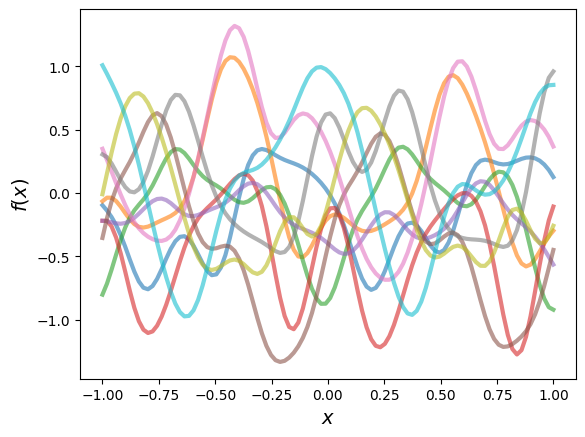

In [51]:
def composite(x, xp):
    return sqexp(x,xp) * periodic(x,xp, p=1)
plt.figure()
funcs = sample_functions(XSPACE2, 10, mean_func, composite)
for jj in range(funcs.shape[1]):
    plt.plot(XSPACE2, funcs[:, jj], lw=3, alpha=0.6)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$f(x)$', fontsize=14)
plt.show()

In [52]:
def gpr(xtrain, ytrain, xpred, noise_var, prior_mean,space_cov, pred_data, kernel):
    """Gaussian process regression Algorithm

    Inputs
    -------
    xtrain: (N, ) training inputs
    ytrain: (N, ) training outputs
    xpred:  (M, ) locations at which to make predictions
    noise_var: (N, ) noise at every training output
    mean_func: function to compute the prior mean
    kernel: covariance kernel
    
    Returns
    -------
    pred_mean : (M, ) predicted mean at prediction points
    pred_cov : (M, M) predicted covariance at the prediction points
    --
    """
    start=time.perf_counter()
    cov = build_covariance(xtrain, xtrain, kernel)
    print("3",time.perf_counter()-start)
    # u, s, v = np.linalg.svd(cov)
    # sqrtcov = np.dot(u, np.sqrt(np.diag(s)))

    # pseudoinverse is better conditioned
    start=time.perf_counter()
    invcov = np.linalg.pinv(cov + np.diag(noise_var))
    print("4",time.perf_counter()-start)
    print("......", ytrain - pred_data)
    vec_pred = build_covariance(xpred, xtrain, kernel)
    pred_mean = prior_mean + np.dot(vec_pred, np.dot(invcov, ytrain - pred_data))
    
    # cov_predict_pre = build_covariance(xpred, xpred, kernel)
    cov_predict_up = np.dot(vec_pred, np.dot(invcov, vec_pred.T))
    pred_cov = space_cov - cov_predict_up
    
    return pred_mean, pred_cov

In [53]:
xtrain=  np.array([0,1,2,3,4,5])
ytrain = np.ones(6)
xpred = np.array([0,1,2,3,4,5,6,7])
noise_var = np.ones(6)*(10**-4)  
prior_mean= np.zeros(8)
space_cov= build_covariance(xpred,xpred,sqexp)
pred_data = np.zeros(6)

mean , cov = gpr(xtrain, ytrain, xpred, noise_var, prior_mean,space_cov, pred_data, sqexp)
print(mean)

3 7.505000007768103e-05
4 0.0002602300000944524
...... [1. 1. 1. 1. 1. 1.]
[0.99915503 1.00094244 0.99974169 0.99974169 1.00094244 0.99915503
 0.98746385 0.95861704]


In [54]:
def plot_function_gp(axis, pred_mean, predict_cov, xdata, ydata, xpred,xtrue, ytrue, title, label):
    axis.plot(xdata, ydata, 'o', ms=10, label='data')
    axis.plot(xtrue, ytrue, '-', lw=3, color='black', label='true function')
    axis.plot(xpred, pred_mean, 'r--', lw=3, label=label)
    pred_fstd = np.sqrt(np.diag(predict_cov))
    axis.fill_between(xpred, pred_mean - 2*pred_fstd, pred_mean+2*pred_fstd, lw=3, label=r'2$\sigma$', color='red', alpha=0.2)
    axis.legend()
    axis.set_title(title, fontsize=14)

1669691378.8185034
bag data start :  3.000154733657837 time interval : 0.0  -  1.9999160766601562 traj end-  8.000002145767212


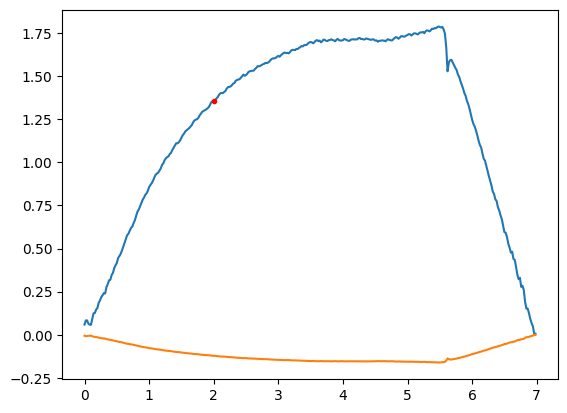

(400,)
100


In [62]:

file = open('velocity-2023-04-18-23-54-05.dat', 'rb')
data = pickle.load(file)
file.close()

data = np.asarray(data)
print(data[150,0])
data[:,0] = data[:,0] - data[0,0]
# Subsample data : 
ref_data = np.copy(data[150:500,:])
ref_data[:,0] = ref_data[:,0]- ref_data[0,0]
# ref_data = data[800:1200,:]
start = 00
end = 100
print("bag data start : ", data[150,0],"time interval :", ref_data[start,0], " - ", ref_data[end,0],"traj end- " , data[400,0])
# scale [-1,1]
# ref_data[:,0] = 2*ref_data[:,0]/(ref_data[-1,0]-ref_data[0,0]) 
# ref_data[:,0] = ref_data[:,0] + (-1 - ref_data[0,0])
data_pts = ref_data[start:end,:]

plt.plot(ref_data[:,0],ref_data[:,1])
plt.plot(ref_data[:,0],ref_data[:,2])
plt.plot(ref_data[end,0],ref_data[end,1], ".r")
plt.show()

pred_hori = 3
time_step = 0.01
XSPACE = data_pts[:,0] - data_pts[0,0]
XSPACE = np.hstack((XSPACE,np.linspace(0,pred_hori, int (pred_hori/time_step)) + data_pts[-1,0]))
print(XSPACE.shape)
#NUM_DATA = 20
# NUM_DATA = 100
NUM_DATA = len(data_pts)
print(NUM_DATA)
#NUM_DATA = 100 
NOISE_COV = 1e-4
layers = 4



#XDATA = np.random.rand(NUM_DATA)*2.0 - 1.0 # randomly spaced data
data_idx = np.random.choice(data_pts.shape[0],NUM_DATA, replace = False)
XDATA = data_pts[:, 0] # linearly space data
YDATA = data_pts[:, 1]
# YTRUE =ref_data[:,1] 

# XDATA_1 = data_pts[:int(NUM_DATA/2), 0]
# XDATA_2 = data_pts[int(NUM_DATA/2):, 0] # linearly space data
# YDATA_1 = data_pts[:int(NUM_DATA/2), 1]
# YDATA_2 = data_pts[int(NUM_DATA/2):,1]

YTRUE =ref_data[:,1] 
XTRUE = ref_data[:,0]

In [63]:


def gp_regression_demo(mean_func, kernel, xdata, ydata, xspace,xtrue ,ytrue, layers,noise_cov=1e-1):
    
    for i in range(layers):
      sub_xdata = xdata[int(NUM_DATA/layers)*i:int(NUM_DATA/layers)*(i+1)]
      sub_ydata=ydata[int(NUM_DATA/layers)*i:int(NUM_DATA/layers)*(i+1)]

      if i ==0:
        prior_mean = mean_func(xspace)
        print(prior_mean)
        prior_cov = build_covariance(xspace, xspace, kernel)
      else:
        prior_mean = mean_predict
        prior_cov = cov_predict

      space_cov = build_covariance(xspace, xspace, kernel)

      start = time.perf_counter()
      
      print("1",time.perf_counter()-start)
      fig, axis = plt.subplots(1, 2, figsize=(15, 5))
      plot_function_gp(axis[0], prior_mean, prior_cov, sub_xdata, sub_ydata,xspace, xtrue, ytrue, "Prior", "Prior mean")
      
      # perform inference
      start = time.perf_counter()
      prior_pred_data = prior_mean[int(NUM_DATA/layers)*i:int(NUM_DATA/layers)*(i+1)]
      mean_predict, cov_predict = gpr(sub_xdata, sub_ydata, xspace, noise_cov * np.ones((sub_xdata.shape[0])), prior_mean,space_cov,prior_pred_data, kernel)
      print("2",time.perf_counter()-start)
      plot_function_gp(axis[1], mean_predict, cov_predict, sub_xdata, sub_ydata, xspace,xtrue, ytrue, "Posterior", "Posterior mean")
      
      plt.show()

    # prior_mean = mean_predict
    # start = time.perf_counter()
    # prior_cov = cov_predict
    # print("1",time.perf_counter()-start)
    # fig, axis = plt.subplots(1, 2, figsize=(15, 5))
    # plot_function_gp(axis[0], prior_mean, prior_cov, xdata_2, ydata_2, xtrue, ytrue, "Prior", "Prior mean")
    
    # # perform inference
    # start = time.perf_counter()
    # prior_pred_data = prior_mean[len(xdata_1):len(xdata_1)+len(xdata_2)]
    # mean_predict, cov_predict = gpr(xdata_2, ydata_2, xtrue, noise_cov * np.ones((xdata_2.shape[0])), prior_mean,prior_pred_data, kernel)
    # print("2",time.perf_counter()-start)
    # plot_function_gp(axis[1], mean_predict, cov_predict, xdata_2, ydata_2, xtrue, ytrue, "Posterior", "Posterior mean")
    
    # plt.show()
    

# always use zero mean

#MEANF = lambda x: 10*x**2
#MEANF = lambda x: true_function(x)
MEANF = lambda x: np.ones((x.shape[0]))*np.mean(YDATA)

In [64]:
# Squared Exponential Kernel
@interact_manual(tau=(0.5,4,0.1), log_width=(-2, 2., 0.05), log_noise_learn=(-10,0,0.2))
def sqexp_infer(tau=0.7, log_width=0.7, log_noise_learn=-4):
    kernel_tot = KERNELS['Sq.Exp']
    def kernel(x, xp):
        return kernel_tot(x, xp, tau=tau, l=10**log_width)
    gp_regression_demo(MEANF, kernel, XDATA, YDATA, XSPACE,XTRUE, YTRUE, layers,noise_cov=10**log_noise_learn)
    # gp_regression_demo(MEANF, kernel, XDATA, YDATA, XSPACE, YTRUE, noise_cov=10**log_noise_learn)

interactive(children=(FloatSlider(value=0.7, description='tau', max=4.0, min=0.5), FloatSlider(value=0.7, desc…

Some goods params:
tau = 1.3; width = 0.2; noise = -3
tau = 0.7; width = 0.7; noise = -4

for flat featureless: 
tau =0.5 ; width= 0.2 ; noise = -3

---



In [58]:
# Periodic Exponential
@interact_manual(c=(0.5,3,0.1), d=(1, 5, 0.5), log_noise_learn=(-10,0,1))
def poly_infer(c=1, d=3, log_noise_learn=np.log10(NOISE_COV)):
    kernel_tot = KERNELS['Poly']
    def kernel(x, xp):
        return kernel_tot(x, xp, c=c, d=d)
    gp_regression_demo(MEANF, kernel, XDATA, YDATA, XSPACE, XTRUE,YTRUE, noise_cov=10**log_noise_learn)

interactive(children=(FloatSlider(value=1.0, description='c', max=3.0, min=0.5), FloatSlider(value=3.0, descri…

In [59]:
@interact_manual(tau=(0.5,2,0.1), log_width_sq=(-4, 1, 0.5), p=(0.1,1.8,0.1), log_width_per=(-4, 1, 0.5), log_noise_learn=(-10,0,1))
def sqexp_infer(tau=1, log_width_sq=0, log_width_per=0, p=1, log_noise_learn=np.log10(NOISE_COV)):
    kernel_tot_sq = KERNELS['Sq.Exp']
    kernel_tot_per = KERNELS['Periodic']
    def kernel(x, xp):
        k1 = kernel_tot_sq(x, xp, tau=tau, l=10**log_width_sq)
        k2 = kernel_tot_per(x, xp, tau=tau, l=10**log_width_per, p=p)
        return k1 * k2
    gp_regression_demo(MEANF, kernel, XDATA, YDATA, XSPACE, YTRUE, layers,noise_cov=10**log_noise_learn)

interactive(children=(FloatSlider(value=1.0, description='tau', max=2.0, min=0.5), FloatSlider(value=0.0, desc…

This is also good composites are good:
tau = 0.9; width_sq_exp = -0.5; width_per: 0.5; p =1 noise = -1

sq and periodic is knda nice best of best worlds:
for flat featureless
tau = 0.5 ; width = 0.2 ; p= 1 width_p = 1 ; noise = -3

In [60]:
@interact_manual(tau=(0.5,2,0.1) , log_width_sq=(-4, 1, 0.1), c=(0.1,3,0.1), d=(1, 10, 0.5), log_noise_learn=(-10,0,1))
def sqexp_infer(tau=1, log_width_sq=0, c=1, d=3, log_noise_learn=np.log10(NOISE_COV)):
    kernel_tot_sq = KERNELS['Sq.Exp']
    kernel_tot_per = KERNELS['Poly']
    def kernel(x, xp):
        k1 = kernel_tot_sq(x, xp, tau=tau, l=10**log_width_sq)
        k2 = kernel_tot_per(x, xp, c=c, d=d)
        return k1 * k2

    start = time.perf_counter()
    gp_regression_demo(MEANF, kernel, XDATA, YDATA, XSPACE, YTRUE, noise_cov=10**log_noise_learn)
    print(time.perf_counter()-start)

interactive(children=(FloatSlider(value=1.0, description='tau', max=2.0, min=0.5), FloatSlider(value=0.0, desc…

this ones nice composite kernal sq ex and polynomial:
tau = 0.9; width = -0.4; c= 1; d = 2.5 noise = -1